In [6]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Encoder,Decoder,VAE,CellStateEncoder,\
                   CellStateDecoder, CellStateVAE,\
                   SimpleEncoder,LocalDiscriminator,PriorDiscriminator,\
                   EmbInfomax,MultiEncInfomax
# import argparse
import math
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

#from scipy.stats import pearsonr
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy
import seaborn as sns
sns.set()

In [7]:
device = torch.device('cuda')

In [8]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HT29_A375.csv',index_col = 0)
#cmap = pd.read_csv('cmap_HT29_A375.csv',index_col = 0)
cmap_extra = pd.read_csv('../preprocessing/preprocessed_data/cmap_PC3_MCF7_landmarks.csv',index_col = 0)

gene_size = len(cmap.columns)
samples = cmap.index.values



In [9]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

### Run adding PC3 model

In [17]:
NUM_EPOCHS = 2000
# bs_pc3 = 200
# bs_ht29_paired = 100
# bs_a375_paired = 100
bs_pc3 = 180
bs_ht29_paired = 80
bs_a375_paired = 80
beta=1.0

bs_a375 = 178
bs_ht29 = 154
bs_paired = 90

In [18]:
# trainloader_pc3 = getSamples(N_pc3, bs_pc3)
# len_pc3 = len(trainloader_pc3)
# trainloader_paired_ht29 = getSamples(N_ht29_paired, bs_ht29_paired)
# len_paired_ht29 = len(trainloader_paired_ht29)
# trainloader_paired_a375 = getSamples(N_a375_paired, bs_a375_paired)
# len_paired_a375 = len(trainloader_paired_a375)
        
# trainloader_a375 = getSamples(N_a375, bs_a375)
# len_a375 = len(trainloader_a375)
# trainloader_ht29 = getSamples(N_ht29, bs_ht29)
# len_ht29 = len(trainloader_ht29)
# trainloader_paired = getSamples(N_paired, bs_paired)
# len_paired = len(trainloader_paired)

# lens = [len_pc3,len_paired_ht29,len_paired_a375,len_a375,len_ht29,len_paired]
# lens

In [19]:
valR2 = []
valPear = []
valMSE =[]
valSpear = []
valAccuracy = []


valPearDirect = []
valSpearDirect = []
valAccDirect = []

valR2_pc3 = []
valPear_pc3 = []
valMSE_pc3 =[]
valSpear_pc3 = []
valAccuracy_pc3 = []


valR2_a375 = []
valPear_a375 = []
valMSE_a375 =[]
valSpear_a375 = []
valAccuracy_a375 = []

valR2_ht29 = []
valPear_ht29 = []
valMSE_ht29 =[]
valSpear_ht29 = []
valAccuracy_ht29 = []

# decoder_a375 = torch.load('../results/MI_results/models/AllData_Model/decoder_a375.pt')
# decoder_ht29 = torch.load('../results/MI_results/models/AllData_Model/decoder_ht29.pt')
# prior_d = torch.load('../results/MI_results/models/AllData_Model/priorDiscr.pt')
# local_d = torch.load('../results/MI_results/models/AllData_Model/localDiscr.pt')
# encoder_a375 = torch.load('../results/MI_results/models/AllData_Model/encoder_a375.pt')
# encoder_ht29 = torch.load('../results/MI_results/models/AllData_Model/encoder_ht29.pt')

# decoder_a375.eval()
# decoder_ht29.eval()
# encoder_a375.eval()
# encoder_ht29.eval()

# for param in decoder_a375.parameters():
#     param.requires_grad = False
# for param in decoder_ht29.parameters():
#     param.requires_grad = False
# for param in encoder_a375.parameters():
#     param.requires_grad = False
# for param in encoder_ht29.parameters():
#     param.requires_grad = False
        

#model_mi.eval()
#trainLoss = []
for i in range(10):
    
    #decoder_a375 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_MI2/decoder_a375_%s.pt'%i)
    #decoder_ht29 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_MI2/decoder_ht29_%s.pt'%i)
    #prior_d = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_MI2/priorDiscr_%s.pt'%i)
    #local_d = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_MI2/localDiscr_%s.pt'%i)
    #encoder_a375 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_MI2/encoder_a375_%s.pt'%i)
    #encoder_ht29 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_MI2/encoder_ht29_%s.pt'%i)
    
    decoder_a375 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
    decoder_ht29 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
    prior_d = PriorDiscriminator(292).to(device)
    local_d = LocalDiscriminator(292,292).to(device)
    encoder_a375 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU()).to(device)
    encoder_ht29 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU()).to(device)
    
    #decoder_a375.eval()
    #decoder_ht29.eval()
    #encoder_a375.eval()
    #encoder_ht29.eval()
    
    #for param in decoder_a375.parameters():
    #    param.requires_grad = False
    #for param in decoder_ht29.parameters():
    #    param.requires_grad = False
    #for param in encoder_a375.parameters():
    #    param.requires_grad = False
    #for param in encoder_ht29.parameters():
    #    param.requires_grad = False
    
    
    # Network
    #decoder_pc3 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
    decoder_pc3 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)

    #master_encoder = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())#.to(device)
    #encoder_pc3 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.3, activation=torch.nn.ELU()).to(device)
    encoder_pc3 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU()).to(device)
    #model = EmbInfomax(292,master_encoder)
    
    #model = MultiEncInfomax(292,[encoder_a375,encoder_ht29])    
    #model = model.to(device)
    
    trainInfo_paired_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/add_pc3/train_paired_ht29_%s.csv'%i,index_col=0)
    trainInfo_paired_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/add_pc3/train_paired_a375_%s.csv'%i,index_col=0)
    trainInfo_pc3 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/add_pc3/train_pc3_%s.csv'%i,index_col=0)
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired_pc3 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/add_pc3/val_paired_%s.csv'%i,index_col=0)
    valInfo_pc3 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/add_pc3/val_pc3_%s.csv'%i,index_col=0)    
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    N_ht29_paired = len(trainInfo_paired_ht29)
    N_a375_paired = len(trainInfo_paired_a375)
    N_pc3 = len(trainInfo_pc3)
    
    N_paired = len(trainInfo_paired)
    N_a375 = len(trainInfo_a375)
    N_ht29 = len(trainInfo_ht29)
    
    allParams = list(decoder_pc3.parameters())
    allParams = allParams + list(encoder_pc3.parameters())
    allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
    
    allParams = allParams + list(decoder_a375.parameters()) + list(decoder_ht29.parameters())
    allParams = allParams + list(encoder_a375.parameters()) + list(encoder_ht29.parameters())
    
    optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)

    for e in range(0, NUM_EPOCHS):
        decoder_a375.train()
        decoder_ht29.train()
        encoder_a375.train()
        encoder_ht29.train()
        decoder_pc3.train()
        encoder_pc3.train()
        prior_d.train()
        local_d.train()
        #model.train()
        #master_encoder.train()
        
        trainloader_pc3 = getSamples(N_pc3, bs_pc3)
        len_pc3 = len(trainloader_pc3)
        trainloader_paired_ht29 = getSamples(N_ht29_paired, bs_ht29_paired)
        len_paired_ht29 = len(trainloader_paired_ht29)
        trainloader_paired_a375 = getSamples(N_a375_paired, bs_a375_paired)
        len_paired_a375 = len(trainloader_paired_a375)
        
        trainloader_a375 = getSamples(N_a375, bs_a375)
        len_a375 = len(trainloader_a375)
        trainloader_ht29 = getSamples(N_ht29, bs_ht29)
        len_ht29 = len(trainloader_ht29)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)

        lens = [len_pc3,len_paired_ht29,len_paired_a375,len_a375,len_ht29,len_paired]
        #lens = [len_pc3,len_paired_ht29,len_paired_a375]
        maxLen = np.max(lens)

        if maxLen>lens[0]:
            while maxLen>len(trainloader_pc3):
                trainloader_suppl = getSamples(N_pc3, bs_pc3)
                trainloader_pc3 = trainloader_pc3 + trainloader_suppl
        
        if maxLen>lens[1]:
            while maxLen>len(trainloader_paired_ht29):
                trainloader_suppl = getSamples(N_ht29_paired, bs_ht29_paired)
                trainloader_paired_ht29 = trainloader_paired_ht29 + trainloader_suppl
        
        if maxLen>lens[2]:
            while maxLen>len(trainloader_paired_a375):
                trainloader_suppl = getSamples(N_a375_paired, bs_a375_paired)
                trainloader_paired_a375 = trainloader_paired_a375 + trainloader_suppl
                
        if maxLen>lens[3]:
            while maxLen>len(trainloader_a375):
                trainloader_suppl = getSamples(N_a375, bs_a375)
                trainloader_a375 = trainloader_a375 + trainloader_suppl
        
        if maxLen>lens[4]:
            while maxLen>len(trainloader_ht29):
                trainloader_suppl = getSamples(N_ht29, bs_ht29)
                trainloader_ht29 = trainloader_ht29 + trainloader_suppl
        
        if maxLen>lens[5]:
            while maxLen>len(trainloader_paired):
                trainloader_suppl = getSamples(N_paired, bs_paired)
                trainloader_paired = trainloader_paired + trainloader_suppl
                
        for j in range(maxLen):
            dataIndex_paired_a375 = trainloader_paired_a375[j]
            dataIndex__paired_ht29 = trainloader_paired_ht29[j]
            dataIndex_pc3 = trainloader_pc3[j]
            
            dataIndex_a375 = trainloader_a375[j]
            dataIndex_ht29 = trainloader_ht29[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_a375 = trainInfo_a375.iloc[dataIndex_a375,:]
            df_ht29 = trainInfo_ht29.iloc[dataIndex_ht29,:]
            paired_inds = len(df_pairs)
            
            df_pairs_ht29 = trainInfo_paired_ht29.iloc[dataIndex__paired_ht29,:]
            df_pairs_a375 = trainInfo_paired_a375.iloc[dataIndex_paired_a375,:]
            df_pc3 = trainInfo_pc3.iloc[dataIndex_pc3,:]
            paired_inds_ht29 = len(df_pairs_ht29)
            paired_inds_a375 = len(df_pairs_a375)
            
            X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs_a375['sig_id.x']].values,
                                                  cmap.loc[df_pairs['sig_id.x']].values,
                                                  cmap.loc[df_a375.sig_id].values))).float().to(device)
            X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs_ht29['sig_id.x']].values,
                                                  cmap.loc[df_pairs['sig_id.y']].values,
                                                  cmap.loc[df_ht29.sig_id].values))).float().to(device)
                 
            #X_a375 = torch.tensor(cmap.loc[df_pairs_a375['sig_id.x']].values).float().to(device)
            #X_ht29 = torch.tensor(cmap.loc[df_pairs_ht29['sig_id.x']].values).float().to(device)
            #z_a375 = encoder_a375(X_a375)
            #z_ht29 = encoder_ht29(X_ht29)
            
            X_pc3 = torch.tensor(np.concatenate((cmap_extra.loc[df_pairs_a375['sig_id.y']].values,
                                                 cmap_extra.loc[df_pairs_ht29['sig_id.y']].values,
                                                 cmap_extra.loc[df_pc3.sig_id].values))).float().to(device)
                        
            #conditions = np.concatenate((df_pairs_a375.conditionId.values,
            #                             df_pairs_ht29.conditionId.values,
            #                             df_pairs_a375.conditionId.values,
            #                             df_pairs_ht29.conditionId.values,
            #                             df_pc3.conditionId.values))
            conditions = np.concatenate((df_pairs_a375.conditionId.values,
                                         df_pairs.conditionId.values,
                                         df_a375.conditionId.values,
                                         df_pairs_ht29.conditionId.values,
                                         df_pairs.conditionId.values,
                                         df_ht29.conditionId.values,
                                         df_pairs_a375.conditionId.values,
                                         df_pairs_ht29.conditionId.values,
                                         df_pc3.conditionId.values))
            
            size = conditions.size
            conditions = conditions.reshape(size,1)
            conditions = conditions == conditions.transpose()
            conditions = conditions*1
            mask = torch.tensor(conditions).to(device).detach()
            pos_mask = mask
            neg_mask = 1 - mask
            log_2 = math.log(2.)
            optimizer.zero_grad()
            
            z_pc3 = encoder_pc3(X_pc3)
            z_a375 = encoder_a375(X_a375)
            z_ht29 = encoder_ht29(X_ht29)
            
            z_un = local_d(torch.cat((z_a375, z_ht29,z_pc3), 0))
            #z_un = local_d(z_pc3)
            res_un = torch.matmul(z_un, z_un.t())
            
            y_pred_pc3 = decoder_pc3(z_pc3)
            fitLoss_pc3 = torch.mean(torch.sum((y_pred_pc3 - X_pc3)**2,dim=1))
            L2Loss_pc3 = decoder_pc3.L2Regularization(0.01) + encoder_pc3.L2Regularization(0.01)
            loss_pc3 = fitLoss_pc3 + L2Loss_pc3
            
            y_pred_a375 = decoder_a375(z_a375)
            fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1))
            L2Loss_a375 = decoder_a375.L2Regularization(0.01) + encoder_a375.L2Regularization(0.01)
            loss_a375 = fitLoss_a375 + L2Loss_a375
            
            y_pred_ht29 = decoder_ht29(z_ht29)
            fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1))
            L2Loss_ht29 = decoder_ht29.L2Regularization(0.01) + encoder_ht29.L2Regularization(0.01)
            loss_ht29 = fitLoss_ht29 + L2Loss_ht29
            
            
            #silimalityLoss1 = torch.mean(torch.sum((z_a375 - z_pc3[0:paired_inds_a375,:])**2,dim=-1))
            #silimalityLoss2 = torch.mean(torch.sum((z_ht29- z_pc3[paired_inds_a375:(paired_inds_a375+paired_inds_ht29),:])**2,dim=-1))
            silimalityLoss1 = torch.mean(torch.sum((z_a375[0:paired_inds_a375,:] - z_pc3[0:paired_inds_a375,:])**2,dim=-1))
            silimalityLoss2 = torch.mean(torch.sum((z_ht29[0:paired_inds_ht29,:]- z_pc3[paired_inds_a375:(paired_inds_a375+paired_inds_ht29),:])**2,dim=-1))
            silimalityLoss3 = torch.mean(torch.sum((z_ht29[paired_inds_ht29:(paired_inds_ht29+paired_inds),:]- z_a375[paired_inds_a375:(paired_inds_a375+paired_inds),:])**2,dim=-1))
            silimalityLoss = silimalityLoss1 + silimalityLoss2 + silimalityLoss3
            
            p_samples = res_un * pos_mask
            q_samples = res_un * neg_mask

            Ep = log_2 - F.softplus(- p_samples)
            Eq = F.softplus(-q_samples) + q_samples - log_2

            Ep = (Ep * pos_mask).sum() / pos_mask.sum()
            Eq = (Eq * neg_mask).sum() / neg_mask.sum()
            mi_loss = Eq - Ep

            #prior = torch.rand_like(z_pc3)
            prior = torch.rand_like(torch.cat((z_a375, z_ht29, z_pc3), 0))

            term_a = torch.log(prior_d(prior)).mean()
            term_b = torch.log(1.0 - prior_d(torch.cat((z_a375, z_ht29, z_pc3), 0))).mean()
            #term_b = torch.log(1.0 - prior_d(z_pc3)).mean()
            prior_loss = -(term_a + term_b) * beta
            
            loss = loss_pc3  + mi_loss + prior_loss + silimalityLoss + loss_a375 + loss_ht29
            
            loss.backward()
            optimizer.step()
        
            pearson_pc3 = pearson_r(y_pred_pc3.detach().flatten(), X_pc3.detach().flatten())
            r2_pc3 = r_square(y_pred_pc3.detach().flatten(), X_pc3.detach().flatten())
            mse_pc3 = torch.mean(torch.mean((y_pred_pc3.detach() - X_pc3.detach())**2,dim=1))
            
            pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
            r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
            mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
            pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
            r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
            mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))
            
            
        scheduler.step()
        outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
        outString += ', r2_pc3={:.4f}'.format(r2_pc3.item())
        outString += ', pearson_pc3={:.4f}'.format(pearson_pc3.item())
        outString += ', MSE_pc3={:.4f}'.format(mse_pc3.item())
        outString += ', r2_a375={:.4f}'.format(r2_a375.item())
        outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
        outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
        outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
        outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
        outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
        outString += ', MI Loss={:.4f}'.format(mi_loss.item())
        outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
        outString += ', loss={:.4f}'.format(loss.item())
        if (e%250==0):
            print(outString)
    print(outString)
    #trainLoss.append(splitLoss)
    decoder_a375.eval()
    decoder_ht29.eval()
    encoder_a375.eval()
    encoder_ht29.eval()
    prior_d.eval()
    local_d.eval()
    decoder_pc3.eval()
    encoder_pc3.eval()
    #model.eval()
    #master_encoder.eval()
                               
    
    paired_val_inds_pc3 = len(valInfo_paired_pc3)
    paired_val_inds = len(valInfo_paired)
    #paired_val_ctrl_inds = len(valInfo_paired_untreat)
    
    x_a375 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired_pc3['sig_id.x']].values,
                                          cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_a375.sig_id].values))).float().to(device)
    x_ht29 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired_pc3['sig_id.y']].values,
                                          cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_ht29.sig_id].values))).float().to(device)        
                 
    #x_a375 = torch.tensor(cmap.loc[paired_val_inds_pc3['sig_id.x']].values).float().to(device)
    #x_ht29 = torch.tensor(cmap.loc[paired_val_inds_pc3['sig_id.y']].values).float().to(device)
    z_a375 = encoder_a375(x_a375)
    z_ht29 = encoder_ht29(x_ht29)
            
    x_pc3 = torch.tensor(np.concatenate((cmap_extra.loc[valInfo_paired_pc3['sig_id']].values,
                                         cmap_extra.loc[valInfo_pc3.sig_id].values))).float().to(device)
    
    z_latent_pc3 = encoder_pc3(x_pc3)
    xhat_pc3 = decoder_pc3(z_latent_pc3)
    
    x_pc3_equivalent = x_pc3[0:paired_val_inds_pc3,:]
    z_equiv_pc3 = encoder_pc3(x_pc3_equivalent)
    
    r2_pc3 = r_square(xhat_pc3.detach().flatten(), x_pc3.detach().flatten())
    pearson_pc3 = pearson_r(xhat_pc3.detach().flatten(), x_pc3.detach().flatten())
    mse_pc3 = torch.mean(torch.mean((xhat_pc3 - x_pc3)**2,dim=1))
    rhos = []
    for jj in range(xhat_pc3.shape[0]):
        rho,p = spearmanr(x_pc3[jj,:].detach().cpu().numpy(),xhat_pc3[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_pc3.append(np.mean(rhos))
    acc = pseudoAccuracy(x_pc3.detach().cpu(),xhat_pc3.detach().cpu(),eps=1e-6)
    valAccuracy_pc3.append(np.mean(acc))
    
    valR2_pc3.append(r2_pc3.item())
    valPear_pc3.append(pearson_pc3.item())
    valMSE_pc3.append(mse_pc3.item())
    print('Pearson correlation PC3: %s'%pearson_pc3.item())
    print('Spearman correlation PC3: %s'%valSpear_pc3[i])
    print('Pseudo-Accuracy PC3: %s'%valAccuracy_pc3[i])
    
    pearDirect_ht29 = pearson_r(x_pc3_equivalent.detach().flatten(), x_ht29[0:paired_val_inds_pc3,:].detach().flatten())
    pearDirect_a375 = pearson_r(x_pc3_equivalent.detach().flatten(), x_a375[0:paired_val_inds_pc3,:].detach().flatten())
    rhos = []
    for jj in range(x_pc3_equivalent.shape[0]):
        rho,p = spearmanr(x_pc3_equivalent[jj,:].detach().cpu().numpy(),x_ht29[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    spearDirect_ht29 = np.mean(rhos)
    for jj in range(x_pc3_equivalent.shape[0]):
        rho,p = spearmanr(x_pc3_equivalent[jj,:].detach().cpu().numpy(),x_a375[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    spearDirect_a375 = np.mean(rhos)
    
    accDirect_ht29_to_pc3 = np.mean(pseudoAccuracy(x_pc3_equivalent.detach().cpu(),x_ht29[0:paired_val_inds_pc3,:].detach().cpu(),eps=1e-6))
    accDirect_pc3_to_ht29 = np.mean(pseudoAccuracy(x_ht29[0:paired_val_inds_pc3,:].detach().cpu(),x_pc3_equivalent.detach().cpu(),eps=1e-6))
    accDirect_pc3_to_a375 = np.mean(pseudoAccuracy(x_a375[0:paired_val_inds_pc3,:].detach().cpu(),x_pc3_equivalent.detach().cpu(),eps=1e-6))
    accDirect_a375_to_pc3 = np.mean(pseudoAccuracy(x_pc3_equivalent.detach().cpu(),x_a375[0:paired_val_inds_pc3,:].detach().cpu(),eps=1e-6))
    
    x_hat_a375_to_pc3 = decoder_pc3(z_a375[0:paired_val_inds_pc3,:]).detach()
    pearson_a375_to_pc3 = pearson_r(x_hat_a375_to_pc3.detach().flatten(), x_pc3_equivalent.detach().flatten())
    rhos = []
    for jj in range(x_hat_a375_to_pc3.shape[0]):
        rho,p = spearmanr(x_pc3_equivalent[jj,:].detach().cpu().numpy(),x_hat_a375_to_pc3[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_a375_to_pc3 = np.mean(rhos)
    acc_a375_to_pc3 = np.mean(pseudoAccuracy(x_pc3_equivalent.detach().cpu(),x_hat_a375_to_pc3.detach().cpu(),eps=1e-6))
    
    print('Pearson of direct A375 to PC3 translation: %s'%pearDirect_a375.item())
    print('Pearson correlation A375 to PC3: %s'%pearson_a375_to_pc3.item())
    print('Pseudo accuracy A375 to PC3: %s'%acc_a375_to_pc3)
    
    x_hat_pc3_to_a375 = decoder_a375(z_equiv_pc3).detach()
    pearson_pc3_to_a375 = pearson_r(x_hat_pc3_to_a375.detach(), x_a375[0:paired_val_inds_pc3,:].detach())
    rhos = []
    for jj in range(x_hat_pc3_to_a375.shape[0]):
        rho,p = spearmanr(x_a375[jj,:].detach().cpu().numpy(),x_hat_pc3_to_a375[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_pc3_to_a375 = np.mean(rhos)
    acc_pc3_to_a375 = np.mean(pseudoAccuracy(x_a375[0:paired_val_inds_pc3,:].detach().cpu(),x_hat_pc3_to_a375.detach().cpu(),eps=1e-6))
    
    print('Pearson correlation PC3 to A375: %s'%pearson_pc3_to_a375.item())
    print('Pseudo accuracy PC3 to A375: %s'%acc_pc3_to_a375)
    
    x_hat_ht29_to_pc3 = decoder_pc3(z_ht29[0:paired_val_inds_pc3,:]).detach()
    pearson_ht29_to_pc3 = pearson_r(x_hat_ht29_to_pc3.detach(), x_pc3_equivalent.detach())
    rhos = []
    for jj in range(x_hat_ht29_to_pc3.shape[0]):
        rho,p = spearmanr(x_pc3_equivalent[jj,:].detach().cpu().numpy(),x_hat_ht29_to_pc3[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_ht29_to_pc3 = np.mean(rhos)
    acc_ht29_to_pc3 = np.mean(pseudoAccuracy(x_pc3_equivalent.detach().cpu(),x_hat_ht29_to_pc3.detach().cpu(),eps=1e-6))
    
    print('Pearson of direct HT29 to PC3 translation: %s'%pearDirect_ht29.item())
    print('Pearson correlation HT29 to PC3: %s'%pearson_ht29_to_pc3.item())
    print('Pseudo accuracy HT29 to PC3: %s'%acc_ht29_to_pc3)
    
    
    x_hat_pc3_to_ht29 = decoder_ht29(z_equiv_pc3).detach()
    pearson_pc3_to_ht29 = pearson_r(x_hat_pc3_to_ht29.detach(), x_ht29[0:paired_val_inds_pc3,:].detach())
    rhos = []
    for jj in range(x_hat_pc3_to_ht29.shape[0]):
        rho,p = spearmanr(x_ht29[jj,:].detach().cpu().numpy(),x_hat_pc3_to_ht29[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_pc3_to_ht29 = np.mean(rhos)
    acc_pc3_to_ht29 = np.mean(pseudoAccuracy(x_ht29[0:paired_val_inds_pc3,:].detach().cpu(),x_hat_pc3_to_ht29.detach().cpu(),eps=1e-6))
    
    print('Pearson correlation PC3 to HT29: %s'%pearson_pc3_to_ht29.item())
    print('Pseudo accuracy PC3 to HT29: %s'%acc_pc3_to_ht29)
    
    
    xhat_a375 = decoder_a375(z_a375)
    xhat_ht29 = decoder_ht29(z_ht29)
    
    pearson_a375 = pearson_r(xhat_a375.detach().flatten(), x_a375.detach().flatten())
    pearson_ht29 = pearson_r(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
    rhos = []
    for jj in range(xhat_a375.shape[0]):
        rho,p = spearmanr(x_a375[jj,:].detach().cpu().numpy(),xhat_a375[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_a375.append(np.mean(rhos))
    acc = pseudoAccuracy(x_a375.detach().cpu(),xhat_a375.detach().cpu(),eps=1e-6)
    valAccuracy_a375.append(np.mean(acc))
    rhos = []
    for jj in range(xhat_ht29.shape[0]):
        rho,p = spearmanr(x_ht29[jj,:].detach().cpu().numpy(),xhat_ht29[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_ht29.append(np.mean(rhos))
    acc = pseudoAccuracy(x_ht29.detach().cpu(),xhat_ht29.detach().cpu(),eps=1e-6)
    valAccuracy_ht29.append(np.mean(acc))
    
    print('Pearson correlation A375: %s'%pearson_a375.item())
    print('Spearman correlation A375: %s'%valSpear_a375[i])
    print('Pseudo-Accuracy A375: %s'%valAccuracy_a375[i])
    print('Pearson correlation HT29: %s'%pearson_ht29.item())
    print('Spearman correlation HT29: %s'%valSpear_ht29[i])
    print('Pseudo-Accuracy HT29: %s'%valAccuracy_ht29[i])
    
    x_a375_equivalent = x_a375[paired_val_inds_pc3:(paired_val_inds_pc3+paired_val_inds),:]
    x_ht29_equivalent = x_ht29[paired_val_inds_pc3:(paired_val_inds_pc3+paired_val_inds),:]
    
    z_latent_a375_equivalent  = encoder_a375(x_a375_equivalent)
    x_hat_ht29_equivalent = decoder_ht29(z_latent_a375_equivalent).detach()
    pearson_ht29 = pearson_r(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    rhos = []
    for jj in range(x_hat_ht29_equivalent.shape[0]):
        rho,p = spearmanr(x_ht29_equivalent[jj,:].detach().cpu().numpy(),x_hat_ht29_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_ht29 = np.mean(rhos)
    acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_hat_ht29_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson correlation A375 to HT29: %s'%pearson_ht29.item())
    print('Pseudo accuracy A375 to HT29: %s'%acc_ht29)
    
    z_latent_ht29_equivalent  = encoder_ht29(x_ht29_equivalent)
    x_hat_a375_equivalent = decoder_a375(z_latent_ht29_equivalent).detach()
    pearson_a375 = pearson_r(x_hat_a375_equivalent.detach(), x_a375_equivalent.detach())
    rhos = []
    for jj in range(x_hat_a375_equivalent.shape[0]):
        rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_hat_a375_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_a375 = np.mean(rhos)
    acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_hat_a375_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson correlation HT29 to A375: %s'%pearson_a375.item())
    print('Pseudo accuracy HT29 to A375: %s'%acc_a375)
    
    
    valPear.append([pearson_ht29_to_pc3.item(),pearson_pc3_to_ht29.item(),
                    pearson_a375_to_pc3.item(),pearson_pc3_to_a375.item()])
    valSpear.append([rho_ht29_to_pc3,rho_pc3_to_ht29,
                    rho_a375_to_pc3,rho_pc3_to_a375])
    valAccuracy.append([acc_ht29_to_pc3,acc_pc3_to_ht29,
                    acc_a375_to_pc3,acc_pc3_to_a375])    
        
    valPearDirect.append([pearDirect_ht29.item(),pearDirect_a375.item()])
    valSpearDirect.append([spearDirect_ht29,spearDirect_a375])
    valAccDirect.append([accDirect_ht29_to_pc3,accDirect_pc3_to_ht29,
                         accDirect_a375_to_pc3,accDirect_pc3_to_a375])
    
    torch.save(decoder_pc3,'../results/MI_results/models/TwoEncoders_TwoDecoders_MI_withPC3/decoder_pc3_%s.pt'%i)
    torch.save(prior_d,'../results/MI_results/models/TwoEncoders_TwoDecoders_MI_withPC3/priorDiscr_%s.pt'%i)
    torch.save(local_d,'../results/MI_results/models/TwoEncoders_TwoDecoders_MI_withPC3/localDiscr_%s.pt'%i)
    torch.save(encoder_pc3,'../results/MI_results/models/TwoEncoders_TwoDecoders_MI_withPC3/encoder_pc3_%s.pt'%i)

Split 1: Epoch=1/2000, r2_pc3=-2.8406, pearson_pc3=0.2975, MSE_pc3=2.5531, r2_a375=-4.2090, pearson_a375=0.3238, MSE_a375=3.7447, r2_ht29=-3.3900, pearson_ht29=0.3632, MSE_ht29=3.2231, MI Loss=1.9141, Prior Loss=0.7044, loss=10596.6270
Split 1: Epoch=251/2000, r2_pc3=0.5592, pearson_pc3=0.8295, MSE_pc3=0.8345, r2_a375=0.5897, pearson_a375=0.8395, MSE_a375=0.9896, r2_ht29=0.5605, pearson_ht29=0.8397, MSE_ht29=1.0148, MI Loss=-0.6513, Prior Loss=0.0000, loss=2926.9429
Split 1: Epoch=501/2000, r2_pc3=0.6146, pearson_pc3=0.8600, MSE_pc3=0.7704, r2_a375=0.6917, pearson_a375=0.8553, MSE_a375=0.8149, r2_ht29=0.6563, pearson_ht29=0.8707, MSE_ht29=0.8762, MI Loss=-0.6607, Prior Loss=0.0000, loss=2527.2710
Split 1: Epoch=751/2000, r2_pc3=0.6110, pearson_pc3=0.8584, MSE_pc3=0.7812, r2_a375=0.6859, pearson_a375=0.8836, MSE_a375=0.8894, r2_ht29=0.6835, pearson_ht29=0.8530, MSE_ht29=0.7648, MI Loss=-0.6992, Prior Loss=0.0000, loss=2492.6328
Split 1: Epoch=1001/2000, r2_pc3=0.6531, pearson_pc3=0.8629

Split 3: Epoch=2000/2000, r2_pc3=0.6595, pearson_pc3=0.8729, MSE_pc3=0.6895, r2_a375=0.7090, pearson_a375=0.8927, MSE_a375=0.8268, r2_ht29=0.6234, pearson_ht29=0.8446, MSE_ht29=0.8090, MI Loss=-0.6782, Prior Loss=0.0000, loss=2353.3877
Pearson correlation PC3: 0.8313519358634949
Spearman correlation PC3: 0.7940753230928228
Pseudo-Accuracy PC3: 0.811218909021734
Pearson of direct A375 to PC3 translation: 0.4941678047180176
Pearson correlation A375 to PC3: 0.748081386089325
Pseudo accuracy A375 to PC3: 0.7240683935469212
Pearson correlation PC3 to A375: 0.5450800061225891
Pseudo accuracy PC3 to A375: 0.7494603499204726
Pearson of direct HT29 to PC3 translation: 0.4745509922504425
Pearson correlation HT29 to PC3: 0.5385561585426331
Pseudo accuracy HT29 to PC3: 0.7255169279709156
Pearson correlation PC3 to HT29: 0.6089714765548706
Pseudo accuracy PC3 to HT29: 0.7645989547830039
Pearson correlation A375: 0.8639929294586182
Spearman correlation A375: 0.8037635824103981
Pseudo-Accuracy A375: 

Split 6: Epoch=501/2000, r2_pc3=0.6021, pearson_pc3=0.8383, MSE_pc3=0.8076, r2_a375=0.6798, pearson_a375=0.8611, MSE_a375=0.8759, r2_ht29=0.6341, pearson_ht29=0.8497, MSE_ht29=0.9292, MI Loss=-0.6644, Prior Loss=0.0000, loss=2681.3425
Split 6: Epoch=751/2000, r2_pc3=0.6355, pearson_pc3=0.8542, MSE_pc3=0.7700, r2_a375=0.6876, pearson_a375=0.8703, MSE_a375=0.8717, r2_ht29=0.6843, pearson_ht29=0.8544, MSE_ht29=0.7519, MI Loss=-0.6743, Prior Loss=0.0000, loss=2453.6443
Split 6: Epoch=1001/2000, r2_pc3=0.6292, pearson_pc3=0.8553, MSE_pc3=0.7240, r2_a375=0.7163, pearson_a375=0.8864, MSE_a375=0.8339, r2_ht29=0.6806, pearson_ht29=0.8700, MSE_ht29=0.7294, MI Loss=-0.6920, Prior Loss=0.0000, loss=2337.7126
Split 6: Epoch=1251/2000, r2_pc3=0.6602, pearson_pc3=0.8662, MSE_pc3=0.6990, r2_a375=0.6981, pearson_a375=0.8685, MSE_a375=0.7859, r2_ht29=0.6909, pearson_ht29=0.8617, MSE_ht29=0.7846, MI Loss=-0.6957, Prior Loss=0.0000, loss=2311.7981
Split 6: Epoch=1501/2000, r2_pc3=0.6611, pearson_pc3=0.850

Pearson of direct A375 to PC3 translation: 0.4160148501396179
Pearson correlation A375 to PC3: 0.6158961653709412
Pseudo accuracy A375 to PC3: 0.7068447010706123
Pearson correlation PC3 to A375: 0.42419320344924927
Pseudo accuracy PC3 to A375: 0.7028750150366896
Pearson of direct HT29 to PC3 translation: 0.4505714774131775
Pearson correlation HT29 to PC3: 0.46902546286582947
Pseudo accuracy HT29 to PC3: 0.7092505713942018
Pearson correlation PC3 to HT29: 0.5666565895080566
Pseudo accuracy PC3 to HT29: 0.7340310357271743
Pearson correlation A375: 0.8229271769523621
Spearman correlation A375: 0.7812864776180969
Pseudo-Accuracy A375: 0.8028525368322063
Pearson correlation HT29: 0.8522698879241943
Spearman correlation HT29: 0.8030321716131084
Pseudo-Accuracy HT29: 0.8183018533726228
Pearson correlation A375 to HT29: 0.7421985864639282
Pseudo accuracy A375 to HT29: 0.7502556237218814
Pearson correlation HT29 to A375: 0.5328363180160522
Pseudo accuracy HT29 to A375: 0.7197597137014314
Split 

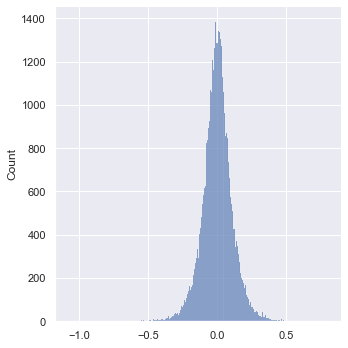

In [25]:
import seaborn as sns
sns.set()
sns.displot(z_a375.flatten().detach().cpu().numpy())

In [21]:
valPear = np.array(valPear)
valPearDirect = np.array(valPearDirect)
valSpear = np.array(valSpear)
valAccuracy= np.array(valAccuracy)
valSpearDirect= np.array(valSpearDirect)
valAccDirect= np.array(valAccDirect)

In [22]:
print(np.mean(valPear,axis=0))
print(np.mean(valPearDirect,axis=0))

[0.46507483 0.51164811 0.66520304 0.50722907]
[0.45465615 0.46487467]


In [23]:
print(np.mean(valSpear,axis=0))
print(np.mean(valSpearDirect,axis=0))

[0.58533753 0.62360328 0.59590191 0.62110303]
[0.40613578 0.40984133]


In [24]:
print(np.mean(valAccuracy,axis=0))
print(np.mean(valAccDirect,axis=0))

[0.70641428 0.72038035 0.70989876 0.71921607]
[0.64109136 0.64109136 0.64215531 0.64215531]


In [26]:
df_result = pd.DataFrame({'pearson_ht29_to_pc3':valPear[:,0],'pearson_pc3_to_ht29':valPear[:,1],
                          'pearson_a375_to_pc3':valPear[:,2],'pearson_pc3_to_a375':valPear[:,3],
                          'spear_ht29_to_pc3':valSpear[:,0],'spear_pc3_to_ht29':valSpear[:,1],
                          'spear_a375_to_pc3':valSpear[:,2],'spear_pc3_to_a375':valSpear[:,3],
                          'acc_ht29_to_pc3':valAccuracy[:,0],'acc_pc3_to_ht29':valAccuracy[:,1],
                          'acc_a375_to_pc3':valAccuracy[:,2],'acc_pc3_to_a375':valAccuracy[:,3],
                          'recon_pear':valPear_pc3,'recon_spear':valSpear_pc3 ,'recon_acc':valAccuracy_pc3,
                          'Direct_pearson_ht29':valPearDirect[:,0],'Direct_pearson_a375':valPearDirect[:,1],
                          'Direct_spearman_ht29':valSpearDirect[:,0],'Direct_spearman_a375':valSpearDirect[:,1],
                          'DirectAcc_ht29_to_pc3':valAccDirect[:,0],'DirectAcc_pc3_to_ht29':valAccDirect[:,1],
                          'DirectAcc_a375_to_pc3':valAccDirect[:,2],'DirectAcc_pc3_to_a375':valAccDirect[:,3]})
df_result

,pearson_ht29_to_pc3,pearson_pc3_to_ht29,pearson_a375_to_pc3,pearson_pc3_to_a375,spear_ht29_to_pc3,spear_pc3_to_ht29,spear_a375_to_pc3,spear_pc3_to_a375,acc_ht29_to_pc3,acc_pc3_to_ht29,...,recon_spear,recon_acc,Direct_pearson_ht29,Direct_pearson_a375,Direct_spearman_ht29,Direct_spearman_a375,DirectAcc_ht29_to_pc3,DirectAcc_pc3_to_ht29,DirectAcc_a375_to_pc3,DirectAcc_pc3_to_a375
0,0.477352,0.481841,0.676161,0.510564,0.594422,0.628105,0.613387,0.657143,0.711656,0.724847,...,0.793175,0.811434,0.439836,0.465554,0.417261,0.416814,0.647444,0.647444,0.642536,0.642536
1,0.363778,0.382533,0.656962,0.510727,0.512618,0.515155,0.594779,0.631919,0.681282,0.675208,...,0.786405,0.808384,0.322189,0.421363,0.327459,0.367538,0.612715,0.612715,0.640623,0.640623
2,0.538556,0.608971,0.748081,0.545080,0.656210,0.741779,0.648656,0.705986,0.725517,0.764599,...,0.794075,0.811219,0.474551,0.494168,0.398426,0.409614,0.627925,0.627925,0.635878,0.635878
3,0.422832,0.458472,0.605840,0.438371,0.563689,0.585709,0.554364,0.584598,0.697904,0.707106,...,0.793517,0.808558,0.436779,0.438862,0.406538,0.404856,0.645706,0.645706,0.637935,0.637935
4,0.585248,0.641342,0.772910,0.624267,0.690651,0.728996,0.684524,0.680367,0.760590,0.778520,...,0.797384,0.813686,0.627471,0.627625,0.550474,0.543776,0.709100,0.709100,0.690695,0.690695
5,0.447230,0.513924,0.623779,0.522441,0.526192,0.597197,0.523332,0.581903,0.681118,0.697546,...,0.774141,0.800273,0.424929,0.412846,0.381743,0.370042,0.624881,0.624881,0.622563,0.622563
6,0.435461,0.493642,0.671362,0.482408,0.577412,0.591574,0.604649,0.594431,0.700920,0.707566,...,0.779161,0.801974,0.450948,0.453384,0.397864,0.397833,0.635713,0.635713,0.638502,0.638502
7,0.469025,0.566657,0.615896,0.424193,0.607523,0.644934,0.611231,0.591890,0.709251,0.734031,...,0.770985,0.795520,0.450571,0.416015,0.396771,0.394426,0.635631,0.635631,0.632984,0.632984
8,0.441269,0.487214,0.640091,0.531208,0.555763,0.587370,0.575217,0.589182,0.696063,0.698236,...,0.789219,0.805951,0.434198,0.445302,0.380316,0.386712,0.629218,0.629218,0.636120,0.636120
9,0.469996,0.481886,0.640947,0.483032,0.568895,0.615212,0.548879,0.593611,0.699841,0.716144,...,0.793839,0.809024,0.485088,0.473629,0.404505,0.406804,0.642581,0.642581,0.643717,0.643717


In [27]:
df_result.to_csv('../results/MI_results/retrain_landmarks_10foldvalidation_MIuniform_and_l2sim_2000ep_withpc3.csv')